<a href="https://colab.research.google.com/github/icecore013/image-segmentation-keras/blob/master/2c_model_training_with_patches%26albumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective of the notebook

The aim of this code is to train a semantic segmentation model on the California and Portugal databases.

# Import and configuration variables

In [ ]:
# Loading of our drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'

Mounted at /content/gdrive


In [ ]:
# Installing and importing the desired packages
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Test')
from os import path as op
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
!pip install keras

from sklearn.model_selection import train_test_split

!pip install tifffile
import tifffile

from tqdm import tqdm

from unet_model import simple_unet_model

!pip install albumentations
import albumentations as A

     |████████████████████████████████| 631 kB 5.4 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=114acb35fb14d2c98a8d26d7c96448caa04cae66776cc7853764f2026ac6d11f
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
# Setting the config variables

PATCHIFIED_IMAGES_PATH = '/content/gdrive/MyDrive/Data/Training_data/Final_patches/patchified_images'
PATCHIFIED_MASKS_PATH = '/content/gdrive/MyDrive/Data/Training_data/Final_patches/patchified_masks'

PREDICTION_THRESHOLD = 0.4

IMAGE_SCALING_FACTOR = 10000
MASK_SCALING_FACTOR = 255

PATCH_SIZE = 256

IMG_CHANNELS = 5
MASK_CHANNELS = 1

BATCH_SIZE = 32

TEST_SIZE = 0.2

# Train & test generators

In [ ]:
# Listing the relevant patch filenames
image_filenames = sorted(os.listdir(PATCHIFIED_IMAGES_PATH))
mask_filenames = sorted(os.listdir(PATCHIFIED_MASKS_PATH))

In [ ]:
# Creating the generators
def datagen(image_path_list, mask_path_list, BATCH_SIZE):
  while True:
  
    buffer_images = []
    buffer_masks = []

    transform = A.Compose([
          A.HorizontalFlip(p=0.3),
          A.VerticalFlip(p=0.3),
          A.RandomRotate90(p=0.3),
      ])

    for image, mask in zip(image_path_list, mask_path_list):
      image_arr = tifffile.imread(op.join(PATCHIFIED_IMAGES_PATH, image))
      mask_arr = tifffile.imread(op.join(PATCHIFIED_MASKS_PATH, mask))

      transformed = transform(image=image_arr, mask=mask_arr)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']

      buffer_images.append(transformed_image)
      buffer_masks.append(transformed_mask)

      if len(buffer_images) == BATCH_SIZE:

        final_images = np.array(buffer_images)
        buffer_images = []
        final_masks = np.array(buffer_masks)
        buffer_masks = []

        yield (final_images, final_masks)

      else:
        pass

In [ ]:
# Splitting the learning database in train and validation sets
train_image_path, test_image_path, train_mask_path, test_mask_path = train_test_split(image_filenames, 
                                                                                      mask_filenames, 
                                                                                      test_size=TEST_SIZE)
train_nb_samples = len(train_image_path)
print('The number of training samples is ' + str(train_nb_samples))
test_nb_samples = len(test_image_path)
print('The number of testing samples is ' + str(test_nb_samples))

train_gen = datagen(train_image_path, train_mask_path, 32)
test_gen = datagen(test_image_path, test_mask_path, 32)

The number of training samples is 916
The number of testing samples is 229


In [ ]:
# Checking the dataset generated
train_sample_dataset = next(train_gen)

for i in range(train_sample_dataset[0].shape[0]):
  print(i)

  # Selection of the first 3 channels
  image_rgb = train_sample_dataset[0][i][:, :, :3]
  # Reorder for RGB image:
  #   - Channels from GEE are: 2(B), 3(G), 4(R)
  #   - Expected channels for RGB image: 4(R), 3(G), 2(B)
  image_rgb = image_rgb[:, :, ::-1] * 5

  # Finding the mask in mask_dataset    
  label_2D = train_sample_dataset[1][i][:, :, 0]

  # Display graphs
  plt.figure(figsize=(20, 20))

  plt.subplot(1, 2, 1)
  plt.imshow(image_rgb, vmin=0)
  plt.title("Sentinel 2 RGB image")

  plt.subplot(1, 2, 2)
  plt.imshow(label_2D, cmap='gray', vmin=0, vmax=1)
  plt.title(("Label image"))

  plt.show()

# Defining the model

In [ ]:
# Defining a model
model = simple_unet_model(PATCH_SIZE, PATCH_SIZE, IMG_CHANNELS)

# Training of the model

In [ ]:
from keras.callbacks import EarlyStopping

# Loading a pre-trained model
#model.load_weights('/content/gdrive/MyDrive/Data/model_save/model_patches.hdf5')

# Early stopping callback to capture the best weights
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
#    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Learning launch
history = model.fit(train_gen, 
                    validation_data = test_gen,
                    steps_per_epoch = train_nb_samples // BATCH_SIZE,
                    validation_steps = test_nb_samples // BATCH_SIZE,
                    epochs = 20,
                    callbacks=[early_stopping_monitor],
                    )

Epoch 1/20
28/28 [==============================] - 228s 8s/step - loss: 0.5140 - acc: 0.7424 - f1_m: 0.5293 - precision_m: 0.6719 - recall_m: 0.5113 - iou_metric: 0.3658 - val_loss: 0.3179 - val_acc: 0.8768 - val_f1_m: 0.8162 - val_precision_m: 0.7925 - val_recall_m: 0.8467 - val_iou_metric: 0.5578
Epoch 2/20
28/28 [==============================] - 38s 1s/step - loss: 0.2933 - acc: 0.8720 - f1_m: 0.8311 - precision_m: 0.8072 - recall_m: 0.8642 - iou_metric: 0.6245 - val_loss: 0.2725 - val_acc: 0.8898 - val_f1_m: 0.8284 - val_precision_m: 0.8311 - val_recall_m: 0.8305 - val_iou_metric: 0.5871
Epoch 3/20
28/28 [==============================] - 37s 1s/step - loss: 0.2603 - acc: 0.8808 - f1_m: 0.8445 - precision_m: 0.8076 - recall_m: 0.8898 - iou_metric: 0.6535 - val_loss: 0.2618 - val_acc: 0.8909 - val_f1_m: 0.8290 - val_precision_m: 0.8362 - val_recall_m: 0.8267 - val_iou_metric: 0.6184
Epoch 4/20
28/28 [==============================] - 37s 1s/step - loss: 0.2479 - acc: 0.8861 - f1_m

In [ ]:
# Saving the model
model.save('/content/gdrive/MyDrive/Data/model_save/model_patches_20220213.hdf5')

# Evaluating the model

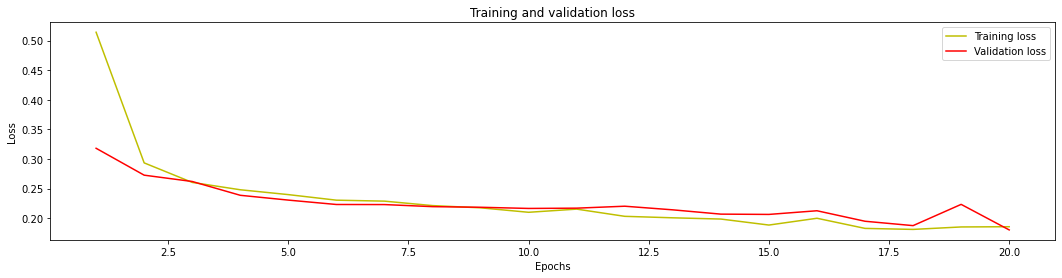

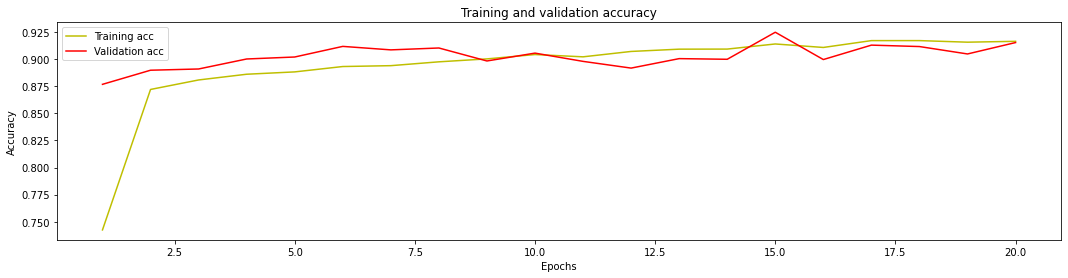

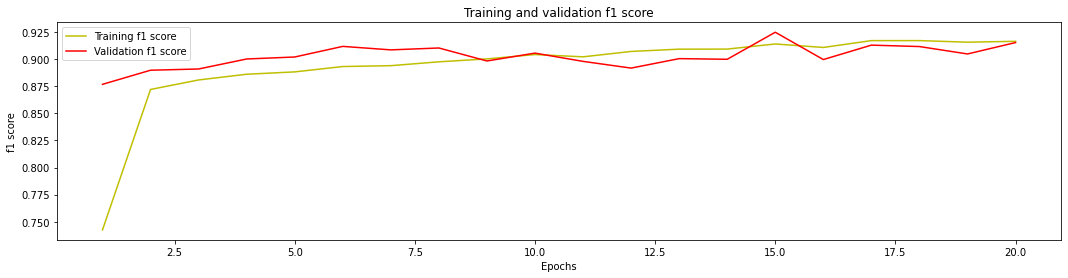

In [ ]:
# Evaluating the performance of the model

# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(18, 4))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(18, 4))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

plt.figure(figsize=(18, 4))
plt.plot(epochs, acc, 'y', label='Training f1 score')
plt.plot(epochs, val_acc, 'r', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('f1 score')
plt.legend()
plt.show()



# Predicting on random test patches

In [ ]:
# Loading the pre-trained model
from sklearn.metrics import roc_curve, auc

# If you want to reload a previous model:
#model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
#model.load_weights('/content/gdrive/MyDrive/Data/model_save/model_test.hdf5')

test_sample_dataset = next(test_gen)

for i in range(test_sample_dataset[0].shape[0]):
  print(i)

  # Collecting the imge and mask
  test_img = test_sample_dataset[0][i][:, :, :3]
  test_img_rgb = test_img[:, :, ::-1] * 4
  test_mask = test_sample_dataset[1][i][:, :, 0]

  # Calculation of the predicted mask
  test_img_input = np.expand_dims(test_sample_dataset[0][i], 0)
  prediction = model.predict(test_img_input)
  final_prediction = (prediction > PREDICTION_THRESHOLD).astype(np.uint8)

  # Data for ROC curve
  test_mask_roc = test_mask.ravel().astype('int16')
  prediction_proba = prediction[0, :, :, 0].ravel()
  fpr, tpr, thresholds = roc_curve(test_mask_roc, prediction_proba)
  roc_auc = auc(fpr,tpr)

  # Figure
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3.5))

  # Showing the test image
  ax1.set_title('Test Image')
  ax1.imshow(test_img_rgb)
  ax1.axis('off')

  # Showing the label image
  ax2.set_title('Test Label')
  ax2.imshow(test_mask, cmap='gray')
  ax2.axis('off')

  # Showing the prediction image
  ax3.set_title('Prediction on test image')
  ax3.imshow(final_prediction[0, :, :, 0], cmap='gray')
  ax3.axis('off')

  # Showing the prediction proba
  ax4.set_title('Prediction proba on test image')
  ax4.imshow(prediction[0, :, :, 0], cmap='gray')
  ax4.axis('off')

  # Showing the ROC curve
  ax5.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
  ax5.plot([0, 1], [0, 1], 'k--')
  ax5.set_xlim([0.0, 1.0])
  ax5.set_ylim([0.0, 1.05])
  ax5.set_xlabel('False Positive Rate')
  ax5.set_ylabel('True Positive Rate')
  ax5.set_title('Receiver Operating Characteristic')
  ax5.legend(loc="lower right")
  plt.show()

  # Best threshold
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print('The best threshold is: ' + str(optimal_threshold))